<a href="https://colab.research.google.com/github/Lazuardis/DESinPython/blob/main/Coffee_%26_Pizza_Eatery_Chapter_2_Identifying_Performance_Metrics_(Queue_%26_Utilization)_and_Visualizing_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Coffee & Pizza Eatery** 🍕🥤



Imagine you run a coffee & pizza eatery just around the corner of city main avenue. You want to observe how the eatery's daily operational take shape as you been told that, for some ocassion, the waiting time is too long, or some customer complaining why the tables are always occupied.

You then managed to gather some data from direct observation. Some data like processing time, customer interarrival time, until customer preference have been collected. And now using discrete event simulation, you try to actually understand how the eatery work, in a more quantitatively representative model.


In [1]:
pip install simpy

In [2]:
# import the corresponding libraries

import simpy
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns


### **Last Chapter 1 Quick Recap: Basic DES Model Building**


#### Defining Input Parameter, Mapping and Modelling Sequence Process Activities, and Building the Python's SimPy Model


---

We will now import and execute the code from the previous chapter, Chapter 1. This code includes input parameters, the sequence of activities in a customer's journey at an eatery, and the main Python model that orchestrates the framework for running and simulating these activities.



#### Before going into Chapter 2: Model Adjustment to represent the system more realistically


---

Before delving into the second chapter, we will make some adjustments to the model to enhance its realism in representing the system. Additionally, we will modify the input parameters to facilitate a more intuitive identification of performance metrics.

These adjustments include:

*   Increasing processing time to create a less optimized system, making it easier to analyze potential improvements.
*   Transitioning from counting customers as a single group to tracking them individually. For instance, if there are two arrivals of two individuals and a group of four, it will be modeled as six individual customers instead of two groups. Management believes this approach makes more sense for evaluating the system.
*   Process of making order will be multiplied by the number of individuals in one set of customer. For example, if one set of customer consist of four people, then the processing time will be 4x longer






In [3]:
# define the neccessary data to be involved in the simulation
# NOTE: time units interpreted across the notebook are in MINUTES

inter_arrival_time = random.expovariate(1/4) #customer arriving in every 4 minutes

processing_time = {
  "till_process": random.uniform(1,3), #till process duration is uniformly distributed from a minute through 3 minutes per customer
  "coffee_process": random.gauss(2,0.5), #coffee making process duration is normally distributed averaging one minute with 0.5 min as standard deviation
  "pizza_process": random.gauss(5,1),
  "dining_in": random.gauss(15,5)
}

**Event 1: Customer Arrival**




In [4]:
def customer_arrival(env, inter_arrival_time):
  global customer
  global customer_served
  customer = 0 #represent the customer ID
  while True: #while the simulation is still in condition to be run
    yield env.timeout(inter_arrival_time)
    customer_type = random.choices([1,2,3,4], [0.4,0.3,0.2,0.1])[0]
    customer += customer_type #customer ID added
    # print(f"customer {customer} arrives at {env.now:7.4f}")

    next_process = till_activity(env, processing_time, customer, customer_type)
    env.process(next_process) #next process is integrated within this function


**Event 2: Till Activity**





In [5]:
def till_activity(env, processing_time, customer, customer_type):
  with staff.request() as till_request: #requesting staff to service at the till
    yield till_request #waiting until the staff available
    yield env.timeout(processing_time["till_process"]) #elapsed time of till activity, staff resource is automatically released after it
    # print(f"till complete at {env.now:7.4f} for customer {customer}")

  order_type = random.randint(1,3) #random assignment for customer ordering type
  dining_in = random.choices([0,1], [0.2,0.8])[0] # 80% of them are down for dine in

  order_coffee = coffee_activity(env, processing_time, customer, customer_type, dining_in)
  order_pizza = pizza_activity(env, processing_time, customer, customer_type, dining_in)
  order_all = coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in)

  if order_type == 1: # if customer order type is only ordering coffee, then proceed to order coffee process
    env.process(order_coffee)
  elif order_type == 2: # same logic with above
    env.process(order_pizza)
  else: env.process(order_all) # if neither only coffee nor only pizza, then they must order both!




**Event 3.1: Coffee Activity**

Only proceed to this sub-event if customer order coffee only

In [6]:
def coffee_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  with staff.request() as coffee_request:
    yield coffee_request
    yield env.timeout(processing_time["coffee_process"]*customer_type)
    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type #customer is successfully served
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave


**Event 3.2: Pizza Activity**

Only proceed to this sub-event if customer order pizza only

In [7]:
def pizza_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  with staff.request() as pizza_request:
    yield pizza_request
    yield env.timeout(processing_time["pizza_process"]*customer_type)
    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 3.3: Coffee & Pizza Activity**

Only proceed to this sub-event if customer order coffee & pizza

In [8]:
def coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  with staff.request() as pizza_request:
    yield pizza_request
    yield env.timeout((processing_time["pizza_process"] + processing_time["coffee_process"])*customer_type)
    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

**Event 4: Dining Activity**





In [9]:
def dining_activity(env, processing_time, customer, customer_type):
  global customer_served
  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      decision = yield twoseater_request | env.timeout(10/60) # the decision is whether there is available two seater or not

      if twoseater_request in decision:
        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}") # after 10 seconds check, customer found no seat available, hence take away
        customer_served += customer_type

  else:
    with four_seater.request() as fourseater_request:
      decision = yield fourseater_request | env.timeout(2) # same exact scenario for group of three or four looking for four seater

      if fourseater_request in decision:
        yield env.timeout(processing_time["dining_in"])
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type



### **Chapter 2: Identifying Performance Metrics and Visualizing Result**

#### Monitoring how crowded the eatery across the time

When operating an eatery, management frequently grapples with understanding the level of crowding in their establishment. Traditionally, their sole method of assessment has been visual observation to determine whether the restaurant is truly crowded or not. However, Discrete Event Simulation (DES) provides them with a means to quantify and justify this assessment more accurately. We will now explore how crowd levels change over the course of an open day using this approach.

Function below is a separated code outside the code for simulating the eatery. It has it means to record the statistics of how many customers inside the eatery across the time, illustrating the system's dynamic

In [10]:
def monitor_customer(env):
  global timestamp
  global customer_in_system
  timestamp = []
  customer_in_system = []
  while True:
    yield env.timeout(5) # for every 5 min of simulation run....
    timestamp.append(env.now) # ...record the timestamp....
    customer_in_system.append(customer - customer_served) # ....and record the number of customer in system




#### Adjustment to Main Model

The main model which previously only contain`env.process(customer_arrival(env, inter_arrival_time))` that represent the function to simulate the eatery system, now is being run parallelly with new process of `monitor_customer(env)` that is also fed to SimPy `env.process()`

The idea of coding both process separately and run it in parallel is because the `monitor_customer` function has its objective to extract data from the main simulation code wheich being independently run.



#### <font color="red">   **BIG NOTE:** *Re-Running this notebook, or doing it in your system might result (both the numerical and the graph) to different result due to random number being generated. Even though we have specified the `random.seed()` function, it would only work within one kernel run.*






TOTAL COMPLETE CUSTOMER:199
Customer in System during simulation end:5911
Average customer in System: 2971.42


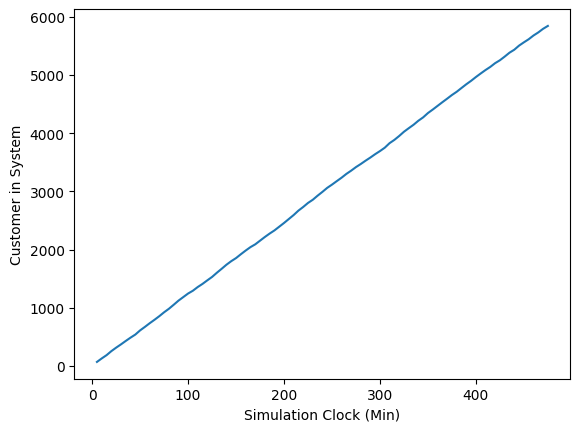

In [11]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 4) # number of staff
two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero

env.process(customer_arrival(env, inter_arrival_time)) # the main 'customer arrival' model that represent the eatery system
env.process(monitor_customer(env)) # the monitoring function is being run in parallel with the main 'customer arrival' model

env.run(until=60*8) # run the simulation for 8 hours
# print('\n')
print(f"TOTAL COMPLETE CUSTOMER:{customer_served}")
print(f"Customer in System during simulation end:{customer - customer_served}")

plt.plot(timestamp, customer_in_system)


# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer in System')

print(f"Average customer in System: {np.mean(customer_in_system):.2f}")




#### Changing the Capacity
We know that from previous simulation run, the average number of customer in system is 5.85 individuals at a time (might be different if you re-run it again).
This result is gained from setting the input parameter, one of which is number of staff, into 4 people.
Let's try setting different number. Let's say we reduce it by 3 staff thus now it's only 1 staff.

TOTAL COMPLETE CUSTOMER:93
Customer in System during simulation end:63
Average customer in System: 35.34


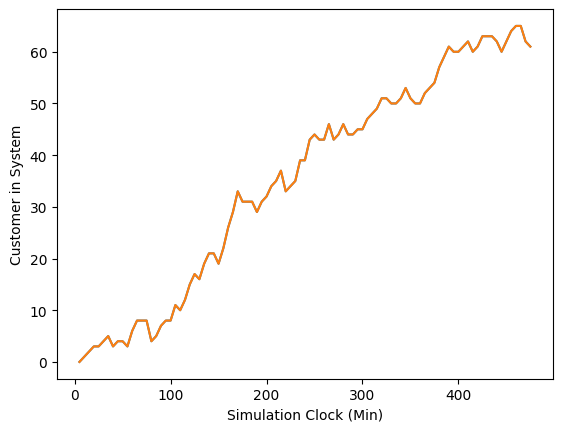

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 1) #staff
two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
env.process(customer_arrival(env, inter_arrival_time))

env.process(monitor_customer(env)) # the monitoring function is being run in parallel with the main 'customer arrival' model that represent the eatery system

env.run(until=60*8) # run the simulation for 3 hours
# print('\n')
print(f"TOTAL COMPLETE CUSTOMER:{customer_served}")
print(f"Customer in System during simulation end:{customer - customer_served}")

plt.plot(timestamp, customer_in_system)


# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer in System')

plt.plot(timestamp, customer_in_system)
print(f"Average customer in System: {np.mean(customer_in_system):.2f}")




**Result**

With just one staff members, the eatery struggles with an overwhelming influx of customers. Customer arrivals far outpace the capacity of the staff to serve them. The queue keeps growing as more customers arrive, resulting in a situation where there are more customers in the system than can be accommodated. This is a more challenging scenario than when there are four staff members. In the four-staff scenario, there are times when the customer count decreases, creating far more stable situation, but with only one staff members, the customer count rising continuously.

#### How the average number of customer varied with different number of staff

Now we know for sure that number of staff definitely affects the number of customer inside the system. The next question is, what is the ideal staff number required for the current system, considering the customer arrival pattern? To determine this, we will vary the staff input parameter from very low to very high and observe how the average customer count within the system changes. This can be accomplished using a 'for loop' function, as demonstrated below.

Text(0, 0.5, 'Average Number of Customer in System')

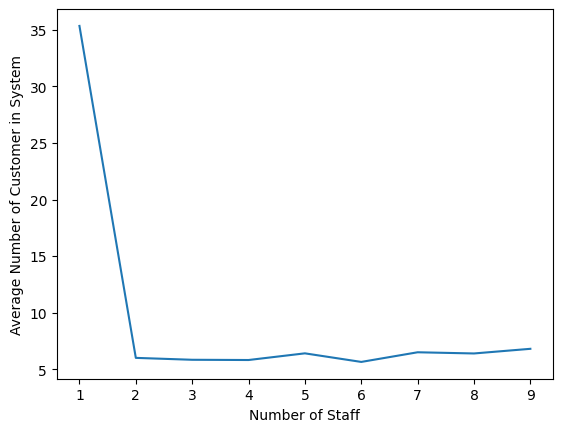

In [ ]:
random.seed(100)
number_of_staff = []
average_customer_in_system = []

for staff_number in range(1,10):
  env = simpy.Environment() #create the essential simpy environment

  staff = simpy.Resource(env, capacity = staff_number) #staff
  two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
  four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

  customer = 0 #set the initial customer id starting from 0
  customer_served = 0 #number of customer served during the start of simulation is zero
  env.process(customer_arrival(env, inter_arrival_time))


  env.process(monitor_customer(env))
  env.run(until=60*8) # run the simulation for 3 hours

  number_of_staff.append(staff_number)
  average_customer_in_system.append(np.mean(customer_in_system))

plt.plot(number_of_staff, average_customer_in_system )
plt.xlabel('Number of Staff')
plt.ylabel('Average Number of Customer in System')


**Result**

The results above are presented in the form of a line chart, illustrating how the average customer count within the system fluctuates with varying staff numbers. As you examine the chart, you'll notice the emergence of an elbow in the line, suggesting that the staff number at which this elbow appears could potentially be the optimal number of staff.

### Being more precise!
---

Excellent! The `monitor_customer` code is now functioning as intended. Reflecting on its development, the code generates a line plot where the x-axis represents timestamps and the y-axis depicts the number of people. The total number of data points, however, amounts to 96. This calculation arises from (60 minutes * 8 hours) divided by 5, with 5 representing the timestamp increment. To derive an average, these 96 data points are averaged.

However, this approach may not be the most accurate. Why is that? Consider a scenario where events, such as customer arrivals or departures, occur within the 5-minute timestamp increment. These events are not recorded by the function, resulting in less accurate monitoring because some time intervals are effectively "skipped." To enhance accuracy, we can reduce the timestamp increment, for instance, to 2 minutes, albeit at the cost of generating more data points. With this adjustment, we would have (60 minutes * 8 hours) divided by 2 data points, providing a more detailed and accurate representation of customer activities.


In [ ]:
# modification to monitor_customer function

def monitor_customer(env):
  global timestamp
  global customer_in_system
  timestamp = []
  customer_in_system = []
  while True:
    yield env.timeout(2) # the timestamp increment now is only 2 minutes
    timestamp.append(env.now)
    customer_in_system.append(customer - customer_served)




TOTAL COMPLETE CUSTOMER:167
Customer in System:1
Average customer in System: 5.878661087866109


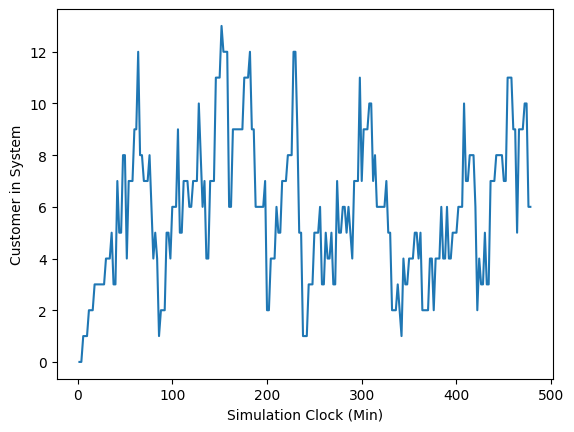

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 4) #staff
two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
env.process(customer_arrival(env, inter_arrival_time))


env.process(monitor_customer(env))
env.run(until=60*8) # run the simulation for 3 hours
# print('\n')
print(f"TOTAL COMPLETE CUSTOMER:{customer_served}")
print(f"Customer in System:{customer - customer_served}")

plt.plot(timestamp, customer_in_system)
# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer in System')

print(f"Average customer in System: {np.mean(customer_in_system)}")




### Introduction of People that Waiting (instead of monitoring the number of customer within the system)
---

We initially chose the "number of customers in the system" as a metric to evaluate our system during simulation. However, after discussions with stakeholders, a different perspective emerged. Monitoring the number of people inside the eatery still lacks clarity. For instance, if there are 20 people inside the eatery and they are all actively dining, there might not be a problem at all.

This realization prompted us to modify the metric. We will now focus solely on customers who are currently waiting inside the eatery. This waiting could be for ordering or for their orders to be prepared. These waiting customers contribute to a queue, which serves as an indicator of potential issues that might need attention. Stakeholders believe that a smaller queue will reflect a more efficient system.

In [ ]:

# introducing variable that track number of people waiting inside the system.

def till_activity(env, processing_time, customer, customer_type):
  global waiting_customer # variable called waiting_customer is created to record how many individuals are waiting
  with staff.request() as till_request:
    waiting_customer += customer_type # the variable is added by customer_type to indicate that the set of customer consisting specific number of individuals are now waiting for the staff at till
    yield till_request
    waiting_customer -= customer_type # after the customer get the staff to service at till, the variable is reduced by the customer_type, indicating that those individuals are waiting no more
    yield env.timeout(processing_time["till_process"])

  order_type = random.randint(1,3)
  dining_in = random.choices([0,1], [0.2,0.8])[0]

  order_coffee = coffee_activity(env, processing_time, customer, customer_type, dining_in)
  order_pizza = pizza_activity(env, processing_time, customer, customer_type, dining_in)
  order_all = coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in)

  if order_type == 1:
    env.process(order_coffee)
  elif order_type == 2:
    env.process(order_pizza)
  else: env.process(order_all)




We need to adjust and integrate the `waiting_customer`variable within all function representing process in which resource is needed. The logic is completely same with above code. To see how it is done towards all remaining acitivity process code, you can expand minimized codes below

In [ ]:
# @title

def coffee_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  global waiting_customer
  with staff.request() as coffee_request:
    waiting_customer += customer_type
    yield coffee_request
    waiting_customer -= customer_type
    yield env.timeout(processing_time["coffee_process"]*customer_type)

    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type #customer is successfully served
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave


In [ ]:
# @title
def pizza_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  global waiting_customer
  with staff.request() as pizza_request:
    waiting_customer += customer_type
    yield pizza_request
    waiting_customer -= customer_type
    yield env.timeout(processing_time["pizza_process"]*customer_type)

    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

In [ ]:
# @title
def coffee_pizza_activity(env, processing_time, customer, customer_type, dining_in):
  global customer_served
  global waiting_customer
  with staff.request() as pizza_request:
    waiting_customer += customer_type
    yield pizza_request
    waiting_customer -= customer_type
    yield env.timeout((processing_time["pizza_process"] + processing_time["coffee_process"])*customer_type)

    # print(f"order complete at {env.now:7.4f} for customer {customer}")

  dining_process = dining_activity(env, processing_time, customer, customer_type)
  if dining_in == 1:
    env.process(dining_process) #if customer intend to dine in, proceed to dine in process
  else:
    customer_served += customer_type
    # print(f"Customer {customer} leaves at {env.now:7.4f}") #if customer intend to take away, they leave

In [ ]:
# @title
def dining_activity(env, processing_time, customer, customer_type):
  global customer_served
  global waiting_customer

  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      waiting_customer += customer_type
      decision = yield twoseater_request | env.timeout(10/60) # the decision is whether there is available two seater or not

      if twoseater_request in decision:
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type

        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}") # after 10 seconds check, customer found no seat available, hence take away
        customer_served += customer_type
        waiting_customer -= customer_type

  else:
    with four_seater.request() as fourseater_request:
      waiting_customer += customer_type
      decision = yield fourseater_request | env.timeout(10/60) # same exact scenario for group of three or four looking for four seater

      if fourseater_request in decision:
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"])
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type

      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        waiting_customer -= customer_type



#### Updating the `monitor_customer` function

As we do not monitor customer in system, we can modify the monitor_customer function to monitor number of waiting customer insted. However, if you still want to monitor that variable, you can create new, another monitor_customer function

In [ ]:
def monitor_customer(env):
  global timestamp
  global waiting_customer_array
  timestamp = []
  waiting_customer_array = []
  while True:
    yield env.timeout(2)
    timestamp.append(env.now)
    waiting_customer_array.append(waiting_customer)

TOTAL COMPLETE CUSTOMER:93
Customer in System:63
Average customer waiting in System: 31.619246861924687


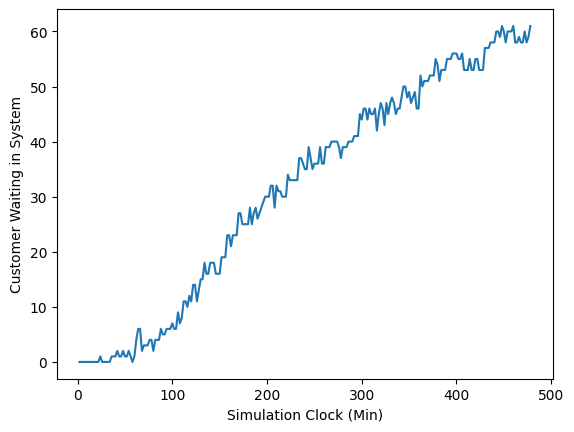

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 1) #staff
two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
waiting_customer = 0
env.process(customer_arrival(env, inter_arrival_time))


env.process(monitor_customer(env))
env.run(until=60*8) # run the simulation for 3 hours
# print('\n')
print(f"TOTAL COMPLETE CUSTOMER:{customer_served}")
print(f"Customer in System:{customer - customer_served}")

plt.plot(timestamp, waiting_customer_array)
# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer Waiting in System')

print(f"Average customer waiting in System: {np.mean(waiting_customer_array)}")




Now let's once again try to input different number of staff parameter ranging from 1 to 10, to observe the elbow.

Text(0, 0.5, 'Average Customer Waiting in System')

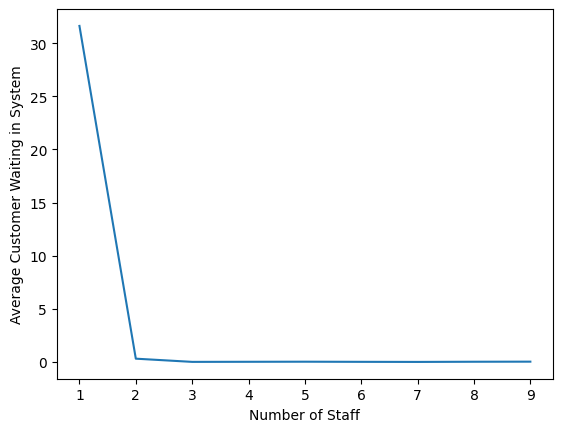

In [ ]:
random.seed(100)
number_of_staff = []
average_waiting_customer = []

for staff_number in range(1,10):
  env = simpy.Environment() #create the essential simpy environment

  staff = simpy.Resource(env, capacity = staff_number) #staff
  two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
  four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

  customer = 0 #set the initial customer id starting from 0
  customer_served = 0 #number of customer served during the start of simulation is zero
  waiting_customer = 0
  env.process(customer_arrival(env, inter_arrival_time))


  env.process(monitor_customer(env))
  env.run(until=60*8) # run the simulation for 3 hours

  number_of_staff.append(staff_number)
  average_waiting_customer.append(np.mean(waiting_customer_array))

plt.plot(number_of_staff, average_waiting_customer )
# Add labels to the x and y axes
plt.xlabel('Number of Staff')
plt.ylabel('Average Customer Waiting in System')

**Result**:

Interestingly, setting number of staff into two or three would effectively eradicate the waiting customer issue. This definitely helps the stakeholder now, convincing them that they would need no more than 2 staff to work under current pattern of demand

### Loss Opportunity and Dissatisfied Customer

---

Well done, we are almost there within the second chapter. Now we want to enhance the modeled system by introducing the concept of loss opportunity and dissatisfied customer. What are those:

*   **Loss Opportunity**: An occurence in which potential customer decides to not enter as they witness there are more than 5 people waiting inside the eatery. They believe they will be waiting long as it will be less convenient
*   **Dissatisfied Customer**: Now customer will not directly leaving the eatery when they intend to dine in meanwhile there is no seat yet available. However, they could only wait for so long, modeled as variable called `willingness_to_wait`. If any seat yet available after they waited for some time reflected on `willingness_to_wait`, they will leave the place quite dissatisfied.

Now, let's get the job done adjusting the code!




In [ ]:
# Integrating logic of LOSS OPPORTUNITY in customer_arrival code

def customer_arrival(env, inter_arrival_time):
  global customer
  global customer_served
  global waiting_customer
  global loss_potential_customer
  loss_potential_customer = 0
  customer = 0 #represent the customer ID
  while True: #while the simulation is still in condition to be run
    yield env.timeout(inter_arrival_time)

    if waiting_customer <= 5:

      customer += 1 #customer ID added
      customer_type = random.choices([1,2,3,4], [0.4,0.3,0.2,0.1])[0]
      # print(f"customer {customer} arrives at {env.now:7.4f}")

      next_process = till_activity(env, processing_time, customer, customer_type)
      env.process(next_process) #next process is integrated within this function
    else:
      loss_potential_customer += 1



In [ ]:
# Integrating logic of DISSATISFIED CUSTOMER in dining_activity code

def dining_activity(env, processing_time, customer, customer_type):
  global customer_served
  global waiting_customer
  global dissatisfied_customer

  willingness_to_wait = random.uniform(15,30)

  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      waiting_customer += customer_type
      decision = yield twoseater_request | env.timeout(willingness_to_wait) # the decision is whether there is available two seater or not

      if twoseater_request in decision:
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type

        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}") # after 10 seconds check, customer found no seat available, hence take away
        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type

  else:
    with four_seater.request() as fourseater_request:
      waiting_customer += customer_type
      decision = yield fourseater_request | env.timeout(willingness_to_wait) # same exact scenario for group of three or four looking for four seater

      if fourseater_request in decision:
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"])
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type

      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        waiting_customer -= customer_type
        dissatisfied_customer += customer_type



Let's run the simulation

Average customer waiting in System: 2.11
Loss Potential Customer Count (Loss Opportunity): 4
Dissatisfied Customer Count: 10


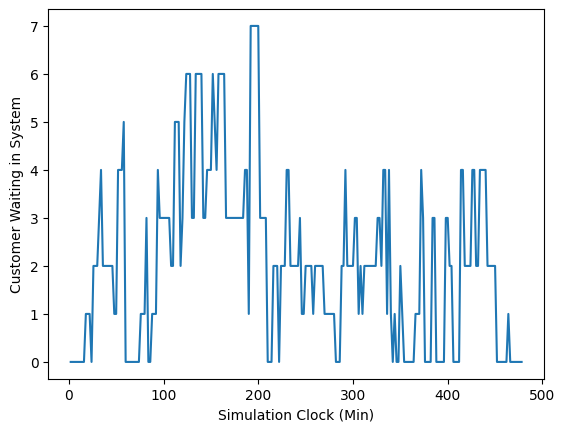

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 2) #staff
two_seater = simpy.Resource(env, capacity = 1) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 1) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 # number of customer served during the start of simulation is zero
waiting_customer = 0
dissatisfied_customer = 0

env.process(customer_arrival(env, inter_arrival_time))
env.process(monitor_customer(env))


env.run(until=60*8) # run the simulation for 3 hours


plt.plot(timestamp, waiting_customer_array)
# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer Waiting in System')

print(f"Average customer waiting in System: {np.mean(waiting_customer_array):.2f}")
print(f"Loss Potential Customer Count (Loss Opportunity): {loss_potential_customer}")
print(f"Dissatisfied Customer Count: {dissatisfied_customer}")




**New Seats Arriving!!**

Great, new seats are arriving from an order of a week ago and now can be utilized. Add them as your input parameter. Now how does the result look

Average customer waiting in System: 0.87
Loss Potential Customer Count (Loss Opportunity): 0
Dissatisfied Customer Count: 0


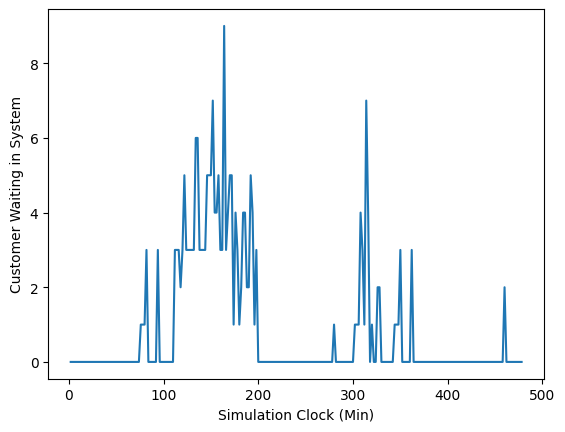

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

staff = simpy.Resource(env, capacity = 2) #staff
two_seater = simpy.Resource(env, capacity = 5) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = 2) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
waiting_customer = 0
dissatisfied_customer = 0


env.process(customer_arrival(env, inter_arrival_time))
env.process(monitor_customer(env))

env.run(until=60*8) # run the simulation for 3 hours


plt.plot(timestamp, waiting_customer_array)
# Add labels to the x and y axes
plt.xlabel('Simulation Clock (Min)')
plt.ylabel('Customer Waiting in System')

print(f"Average customer waiting in System: {np.mean(waiting_customer_array):.2f}")
print(f"Loss Potential Customer Count (Loss Opportunity): {loss_potential_customer}")
print(f"Dissatisfied Customer Count: {dissatisfied_customer}")


**Result**:

Horray, not only adding seats is reducing the average customer waiting in system into great extent, also it effectively reduces the issue of loss potential customer count and dissatisfied customer.

Now, we are being lucky that the arriving new seats has been in plan for long. What if that is not the case, what if the stakeholder instead asking you what is the efficient seats addition so the eatery will not spent too much money for new seats? (psst, you could do the 'elbow' analysis again on this)

## Resource Utilization


---

Talking about spending money on new seats, it is better to evaluate more comprehensively. Whenever we have assets of resources to enable the eatery operation, we also want to know how often that specific resource is being used. Intuitively, we might need new addition of asset if the usage of specific resource is quite high and we know that it is not needed if the utilization is quite low. On this section, we will again update the code so it will able to monitor the utilization of the seaters.



In [ ]:
# Integrate the variable that track seaters utilization in dining_activity function code

def dining_activity(env, processing_time, customer, customer_type):
  global customer_served
  global waiting_customer
  global twoseater_util
  global fourseater_util

  willingness_to_wait = random.uniform(15,30)

  if customer_type <= 2:
    with two_seater.request() as twoseater_request:
      waiting_customer += customer_type
      decision = yield twoseater_request | env.timeout(willingness_to_wait) # the decision is whether there is available two seater or not

      if twoseater_request in decision:
        twoseater_util += 1
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"]) # customer found two seater and dining in
        customer_served += customer_type
        twoseater_util -= 1

        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}") # after 10 seconds check, customer found no seat available, hence take away
        customer_served += customer_type
        waiting_customer -= customer_type

  else:
    with four_seater.request() as fourseater_request:
      waiting_customer += customer_type
      decision = yield fourseater_request | env.timeout(willingness_to_wait) # same exact scenario for group of three or four looking for four seater

      if fourseater_request in decision:
        fourseater_util += 1
        waiting_customer -= customer_type
        yield env.timeout(processing_time["dining_in"])
        # print(f"Dining in complete at {env.now:7.4f} for customer {customer}")
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        fourseater_util -= 1

      else:
        # print(f"Customer {customer} leaves at {env.now:7.4f}")
        customer_served += customer_type
        waiting_customer -= customer_type



In [ ]:
# create monitor_utilization code to track the utilization over time, same logic as monitor_customer

def monitor_utilization(env):
  global timestamp
  global twoseater_util_array
  global fourseater_util_array
  timestamp = []
  twoseater_util_array = []
  fourseater_util_array = []
  while True:
    yield env.timeout(2)
    timestamp.append(env.now)
    twoseater_util_array.append(twoseater_util)
    fourseater_util_array.append(fourseater_util)

Run the main model (now it consist of three parallel process!)

In [ ]:
random.seed(100) #random seed to preserve same random number generated

env = simpy.Environment() #create the essential simpy environment

set_twoseater = 3
set_fourseater = 1

staff = simpy.Resource(env, capacity = 2) #staff
two_seater = simpy.Resource(env, capacity = set_twoseater) #two seater for one or couple customer
four_seater = simpy.Resource(env, capacity = set_fourseater) #four seater for three or four group of customer

customer = 0 #set the initial customer id starting from 0
customer_served = 0 #number of customer served during the start of simulation is zero
waiting_customer = 0
twoseater_util = 0
fourseater_util = 0

env.process(customer_arrival(env, inter_arrival_time))
env.process(monitor_customer(env))
env.process(monitor_utilization(env))

env.run(until=60*8) # run the simulation for 3 hours


print(f"Average customer waiting in System: {np.mean(waiting_customer_array):.3f}")
print(f"Loss Potential Customer Count: {np.mean(loss_potential_customer)}")
print(f"Average usage of two seater: {np.mean(twoseater_util_array):.3f}, and the overall utilization is {np.mean(twoseater_util_array)/set_twoseater:.0%}  ")
print(f"Average usage of four seater: {np.mean(fourseater_util_array):.3f}, and the overall utilization is {np.mean(fourseater_util_array)/set_fourseater:.0%}  ")




Average customer waiting in System: 1.155
Loss Potential Customer Count: 4.0
Average usage of two seater: 0.929, and the overall utilization is 31%  
Average usage of four seater: 0.552, and the overall utilization is 55%  


### How setting different number of seats will affect their overall collective utilization


---

To address this question, we can use two-seater resources as an example and test how different provisions of seats lead to varying utilization rates.


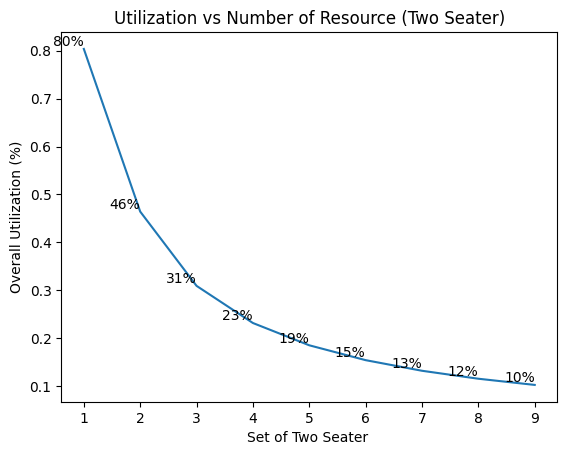

In [ ]:
random.seed(100)
number_of_twoseater = []
twoseater_utilization = []

for set_twoseater in range(1,10):

  random.seed(100) #random seed to preserve same random number generated

  env = simpy.Environment() #create the essential simpy environment

  set_fourseater = 1

  staff = simpy.Resource(env, capacity = 2) #staff
  two_seater = simpy.Resource(env, capacity = set_twoseater) #two seater for one or couple customer
  four_seater = simpy.Resource(env, capacity = set_fourseater) #four seater for three or four group of customer

  customer = 0 #set the initial customer id starting from 0
  customer_served = 0 #number of customer served during the start of simulation is zero
  waiting_customer = 0
  twoseater_util = 0
  fourseater_util = 0

  env.process(customer_arrival(env, inter_arrival_time))
  env.process(monitor_customer(env))
  env.process(monitor_utilization(env))

  env.run(until=60*8) # run the simulation for 3 hours

  number_of_twoseater.append(set_twoseater)
  twoseater_utilization.append(np.mean(twoseater_util_array)/set_twoseater)

plt.plot(number_of_twoseater, twoseater_utilization )

for i, (xi, yi) in enumerate(zip(number_of_twoseater, twoseater_utilization)):
    plt.text(xi, yi, f'{yi:.0%}', ha='right', va='bottom')

# Add labels to the x and y axes
plt.xlabel('Set of Two Seater ')
plt.ylabel('Overall Utilization (%)')

# Title for the plot
plt.title('Utilization vs Number of Resource (Two Seater)')

plt.show()


**Result**:

Based on this result, the utilization of two-seater tables experiences a gradual, apparent decline when they are increased. Stakeholder must be wise enough in deciding how many seats they would need. If it's still quite high, then there must be a high occurence chance of people need to wait for the seat as it is not available.  If it's too low, it is a sign of the seater being too much that it is not really used over time.